# Dados de Belo Horizonte

In [102]:
import geopandas as gpd
import pandas as pd
import shapely.wkt
import pyproj
from functools import partial
from shapely.ops import transform
import numpy as np

## Convesão de coordenadas

In [2]:
project = partial(
      pyproj.transform,
      pyproj.Proj(init='epsg:31983', inverse=True, preserve_units=True), 
      pyproj.Proj(init='epsg:4326', inverse=True,  preserve_units=True)) 

/home/isaac/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/isaac/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/isaac/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the c

## Load Dataset

<AxesSubplot:>

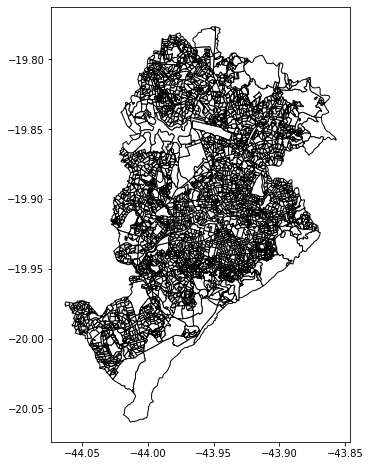

In [3]:
#Mapa de Belo Horizonte
bh=gpd.read_file("Setorescensitários2010/SC_Belo Horizonte 2010.shp")
bh.plot(color='white', edgecolor='black', figsize=(15,8))

In [8]:
#praça
df_praca = pd.read_csv("LayersCovidBH/PRACA.csv")
#parque
df_parque = pd.read_csv("LayersCovidBH/PARQUE.csv")
#faixa de renda
df_renda = pd.read_csv("LayersCovidBH/faixa-renda-bh.csv", sep=';')
#empresa de pequeno porte
df_empr_pq = pd.read_csv("LayersCovidBH/EMPRESA_PEQUENO_PORTE.csv")
#empresa de outros portes
df_empr_outros = pd.read_csv("LayersCovidBH/EMPRESAS_OUTROS_PORTES.csv")
#faixa etaria
df_etaria = pd.read_csv("LayersCovidBH/faixa-etaria-bh.csv", sep=';')
#barrios por codigo
basico = pd.read_excel("Basico_MG.xls")

/home/isaac/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_empr_pq = df_empr_pq.dropna(subset=['GEOMETRIA'])
basico_filter = basico[["Cod_setor", "Nome_do_bairro"]]

## Converte de string para POLIGON/POINT

In [10]:
df_praca["GEOMETRIA"] = df_praca["GEOMETRIA"].apply(shapely.wkt.loads)
df_parque["GEOMETRIA"] = df_parque["GEOMETRIA"].apply(shapely.wkt.loads)
df_empr_pq["GEOMETRIA"] = df_empr_pq["GEOMETRIA"].apply(shapely.wkt.loads)
#df_empr_outros["GEOMETRIA"] = df_empr_outros["GEOMETRIA"].apply(shapely.wkt.loads)                                                     

## Aplicando tranformação de coordenadas

In [11]:
#praça
df_praca["GEOMETRIA_CM"] = 0
for i, praca in enumerate(df_praca["GEOMETRIA"].values):
    df_praca["GEOMETRIA_CM"].iloc[i] = transform(project, praca)

#parque
df_parque["GEOMETRIA_CM"] = 0
for i, parque in enumerate(df_parque["GEOMETRIA"].values):
    df_parque["GEOMETRIA_CM"].iloc[i] = transform(project, parque)

/home/isaac/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Identificação do barrio de acordo às coordenadas

In [13]:
#praça
df_praca["BARRIO"] = 0
for i, praca in enumerate(df_praca["GEOMETRIA_CM"].values):
    #praca=shapely.wkt.loads(shapely.wkt.dumps(praca, rounding_precision=7))
    for b, barrio  in enumerate(bh["geometry"]):
        #barrio=shapely.wkt.loads(shapely.wkt.dumps(barrio, rounding_precision=4))
        if (praca.centroid).within(barrio):
            df_praca["BARRIO"].iloc[i] = bh["NM_BAIRRO"].iloc[b]
            continue

In [14]:
#parque
df_parque["BARRIO"] = 0            
for i, parque in enumerate(df_parque["GEOMETRIA_CM"].values):
    #praca=shapely.wkt.loads(shapely.wkt.dumps(praca, rounding_precision=7))
    for b, barrio  in enumerate(bh["geometry"]):
        #barrio=shapely.wkt.loads(shapely.wkt.dumps(barrio, rounding_precision=4))
        if (parque.centroid).within(barrio):
            df_parque["BARRIO"].iloc[i]= bh["NM_BAIRRO"].iloc[b]
            continue

In [15]:
#empresa de pequeno porte            
df_empr_pq["BARRIO"] = 0            
for i, empr in enumerate(df_empr_pq["GEOMETRIA"].values):
    empr = transform(project, empr)
    for b, barrio  in enumerate(bh["geometry"]):
        if empr.within(barrio):
            df_empr_pq["BARRIO"].iloc[i] = bh["NM_BAIRRO"].iloc[b]
            continue

In [83]:
#empresa de outros portes            
df_empr_outros["BARRIO"] = 0            
for i, empr in enumerate(df_empr_outros["GEOMETRIA"].values):
    try:
        empr = transform(project, shapely.wkt.loads(empr))
    except:
        continue
    for b, barrio  in enumerate(bh["geometry"]):
        if empr.within(barrio):
            df_empr_outros["BARRIO"].iloc[i] = bh["NM_BAIRRO"].iloc[b]
            continue

/home/isaac/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Agrupamento de dados de acordo ao barrio

### faixa etaria

In [49]:
df_etaria_merge = pd.merge(df_etaria, basico_filter)
df_etaria_group = df_etaria_merge.drop(["Situacao_setor"], axis=1).groupby(by="Nome_do_bairro").sum()
print(df_etaria_group.shape)
df_etaria_group.head()

(481, 10)


,Cod_setor,TOTAL,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS
Nome_do_bairro,,,,,,,,,,
Aarão Reis,1553100303300977,2962,31,301,463,521,528,387,346,385
Acaba Mundo,310620005620143,1173,27,237,275,213,185,115,71,50
Acaiaca,1242480242560419,2565,37,318,415,554,373,407,276,185
Ademar Maldonado,1242480102440642,1803,7,162,205,298,326,238,220,347
Aeroporto,931860017040198,1325,5,131,151,335,228,183,118,174


### faixa de renda

In [50]:
df_renda_merge = pd.merge(df_renda, basico_filter)
df_renda_group = df_renda_merge.drop(["Situacao_setor"], axis=1).groupby(by="Nome_do_bairro").sum()
print(df_renda_group.shape)
df_renda_group.head()

(481, 12)


,Cod_setor,ATEMEIOSALARIO,DEMEIOA1SALARIO,DE1A2SALARIOS,DE2A3SALARIOS,DE3A5SALARIOS,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,TOTAL
Nome_do_bairro,,,,,,,,,,,,
Aarão Reis,1553100303300977,44,653,657,229,156,82,10,2,3,794,2962
Acaba Mundo,310620005620143,35,427,156,3,2,1,0,0,0,285,1173
Acaiaca,1242480242560419,27,459,567,219,158,54,5,1,1,719,2565
Ademar Maldonado,1242480102440642,11,223,392,219,204,124,21,6,2,432,1803
Aeroporto,931860017040198,4,143,213,117,156,188,27,25,13,303,1325


### praça

In [67]:
df_praca_group = df_praca.groupby(by="BARRIO").count()["FID"]
print(df_praca_group.shape)
df_praca_group.head()

(266,)


BARRIO
0                   4
Aarão Reis          3
Ademar Maldonado    2
Aeroporto           2
Aguas Claras        1
Name: FID, dtype: int64

### parque

In [68]:
df_parque_group = df_parque.groupby(by="BARRIO").count()["FID"]
print(df_parque_group.shape)
df_parque_group.head()

(62,)


BARRIO
Alto Caiçaras     1
Alto Vera Cruz    1
Alípio de Melo    1
Anchieta          1
Baleia            1
Name: FID, dtype: int64

### empresa de pequeno porte

In [69]:
df_empr_pq_group = df_empr_pq.groupby(by="BARRIO").count()["FID"]
print(df_empr_pq_group.shape)
df_empr_pq_group.head()

(302,)


BARRIO
0                   24
Aarão Reis          10
Acaiaca              8
Ademar Maldonado     6
Aeroporto           54
Name: FID, dtype: int64

### empresa de outros portes

In [86]:
df_empr_outros_group = df_empr_outros.groupby(by="BARRIO").count()["FID"]
print(df_empr_outros_group.shape)
df_empr_outros_group.head()

(383,)


BARRIO
0                   705
Aarão Reis           29
Acaba Mundo           4
Acaiaca               7
Ademar Maldonado      9
Name: FID, dtype: int64

### Agrupamento dos dados em uma só tabela

In [114]:
renda = df_renda_group.rename(columns={"TOTAL": "TOTAL_SALARIOS"})
etaria = df_etaria_group.rename(columns={"TOTAL": "TOTAL_FAIXA_ETARIA"})
bh_group = pd.concat([etaria, renda], axis=1)

In [122]:
bh_group_group = bh_group.join(df_praca_group).rename(columns={"FID": "PRACAS"})
bh_group_group = bh_group_group.join(df_parque_group).rename(columns={"FID": "PARQUES"})
bh_group_group = bh_group_group.join(df_empr_outros_group).rename(columns={"FID": "EMPRESAS OUTROS GROUPOS"})
bh_group_group = bh_group_group.join(df_empr_pq_group).rename(columns={"FID": "EMPRESAS PEQUENO PORTE"})
bh_group_group = bh_group_group .replace(np.nan,0)
bh_group_group.head()

,Cod_setor,TOTAL_FAIXA_ETARIA,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,...,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,TOTAL_SALARIOS,PRACAS,PARQUES,EMPRESAS OUTROS GROUPOS,EMPRESAS PEQUENO PORTE
Nome_do_bairro,,,,,,,,,,,,,,,,,,,,,
Aarão Reis,1553100303300977,2962,31,301,463,521,528,387,346,385,...,82,10,2,3,794,2962,3.0,0.0,29.0,10.0
Acaba Mundo,310620005620143,1173,27,237,275,213,185,115,71,50,...,1,0,0,0,285,1173,0.0,0.0,4.0,0.0
Acaiaca,1242480242560419,2565,37,318,415,554,373,407,276,185,...,54,5,1,1,719,2565,0.0,0.0,7.0,8.0
Ademar Maldonado,1242480102440642,1803,7,162,205,298,326,238,220,347,...,124,21,6,2,432,1803,2.0,0.0,9.0,6.0
Aeroporto,931860017040198,1325,5,131,151,335,228,183,118,174,...,188,27,25,13,303,1325,2.0,0.0,124.0,54.0


In [123]:
bh_group_group.describe()

,Cod_setor,TOTAL_FAIXA_ETARIA,ABAIXO1ANO,1A9ANOS,10A19ANOS,20A29ANOS,30A39ANOS,40A49ANOS,50A59ANOS,ACIMA60ANOS,...,DE5A10SALARIOS,DE10A15SALARIOS,DE15A20SALARIOS,MAISDE20SALARIOS,SEMSALARIO,TOTAL_SALARIOS,PRACAS,PARQUES,EMPRESAS OUTROS GROUPOS,EMPRESAS PEQUENO PORTE
count,4.810000e+02,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,2.515312e+15,4937.943867,55.642412,521.397089,734.860707,932.740125,814.945946,693.841996,554.018711,621.719335,...,332.417879,78.318087,69.769231,64.101871,1306.214137,4937.943867,1.586279,0.164241,123.802495,38.970894
std,2.660989e+15,5555.748404,64.396210,577.574900,787.868524,1050.052836,957.073132,807.835748,679.664698,835.470842,...,681.377708,203.641486,212.503977,233.005293,1423.758631,5555.748404,2.366727,0.478768,358.217381,119.486467
min,3.106200e+14,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,6.212400e+14,819.000000,11.000000,110.000000,154.000000,157.000000,130.000000,108.000000,75.000000,60.000000,...,3.000000,0.000000,0.000000,0.000000,254.000000,819.000000,0.000000,0.000000,1.000000,0.000000
50%,1.553100e+15,2962.000000,33.000000,314.000000,468.000000,573.000000,469.000000,402.000000,287.000000,278.000000,...,42.000000,5.000000,2.000000,2.000000,829.000000,2962.000000,1.000000,0.000000,14.000000,4.000000
75%,3.416821e+15,7075.000000,76.000000,734.000000,1067.000000,1328.000000,1161.000000,996.000000,792.000000,846.000000,...,336.000000,49.000000,26.000000,15.000000,1832.000000,7075.000000,2.000000,0.000000,91.000000,30.000000
max,1.801596e+16,34395.000000,489.000000,3463.000000,4147.000000,6164.000000,7330.000000,5241.000000,4869.000000,5703.000000,...,5460.000000,2023.000000,1835.000000,2533.000000,8217.000000,34395.000000,15.000000,3.000000,3596.000000,1673.000000


In [127]:
bh_group_group.to_excel("data_bh.xlsx")